In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from dataloader import DataLoader
from model import Model
from conf import *

In [3]:
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
directory = "./data/"

In [5]:
learning_rate = 1e-3
train_batch_size = 9
val_batch_size = 5
split_rate = 0.2
EPOCH = 100
BLANK = len(CLASSES)

In [6]:
dl = DataLoader(directory, split_rate)

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 109.40it/s]


In [7]:
def evaluate(data, model_for_eval, bs, dl):
    acc, tot, word_acc, word_tot = 0, 0, 0, len(data)
    L = len(data) // bs
    for l in range(L):
        X, y, _, _ = dl.extract_batch(data, l, bs, device)
        model_for_eval.eval()
        with torch.no_grad():
            yp = model_for_eval(X)
            yp = nn.functional.log_softmax(yp, dim=2)
            for j in range(bs):
                ypp = torch.argmax(yp[:, j, :], dim=1)
                ypp = list(ypp)
                s = ""
                for i in ypp:
                    if i == BLANK:
                        s = s + "_"
                    else:
                        s = s + str(int(i))
                ans = [str(int(e)) for e in y[j]]
                ans = [a for a in ans if a != str(BLANK)]
                ans = "".join(ans)
                s = output_ctc(s)
                word_acc += ans == s
                tot += len(ans)
                for cahr in range(len(ans)):
                    if cahr >= len(s):
                        break
                    acc += s[cahr] == ans[cahr]
    return word_acc / word_tot , acc / tot

In [8]:
def train(model, epoch, train_set, val_set, dl, train_batch_size, val_batch_size, optimizer, criterion, device):
    LOSS = []
    WORD_ACC = []
    WORD_VAL_ACC = []
    ACC = []
    VAL_ACC = []
    for ep in tqdm(range(1, epoch + 1)):
        model.train()
        LOSS.append(0)
        if ep > 1:
            np.random.shuffle(train_set)
        for b in range(len(train_set) // train_batch_size):
            X, y, target_lengths, bs = dl.extract_batch(train_set, b, train_batch_size, device)
            optimizer.zero_grad()
            yp = model(X)
            yp = nn.functional.log_softmax(yp, dim=2)
            input_lengths = torch.LongTensor([yp.shape[0]] * bs).to(device)
            loss = criterion(yp, y, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            LOSS[-1] += (float(loss) / (len(train_set) // train_batch_size))
        word_acc , acc = evaluate(train_set, model, train_batch_size, dl)
        WORD_ACC.append(word_acc)
        ACC.append(acc)
        word_acc , acc = evaluate(val_set, model, val_batch_size, dl)
        WORD_VAL_ACC.append(word_acc)
        VAL_ACC.append(acc)
        if LOSS[-1] < 0.05:
            break
    return LOSS, ACC, WORD_ACC, VAL_ACC, WORD_VAL_ACC

In [9]:
def result_ith(i, epoch, train_batch_size, val_batch_size, device, learning_rate, blank):
    model = Model().to(device)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    criterion = nn.CTCLoss(blank=blank)
    dl.train_val_split(i)
    train_set, val_set = dl.train, dl.val
    train_set = sorted(train_set, key=lambda x: len(x[1]), reverse=False)
    LOSS, ACC, WORD_ACC, VAL_ACC, WORD_VAL_ACC = train(model,
                                                       epoch,
                                                       train_set,
                                                       val_set,
                                                       dl,
                                                       train_batch_size,
                                                       val_batch_size,
                                                       optimizer,
                                                       criterion,
                                                       device)
    fix, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(LOSS)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')


    ax[1].plot(ACC, label='accuracy')
    ax[1].plot(VAL_ACC, label = 'val_accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='upper left')

    ax[2].plot(WORD_ACC, label='word_accuracy')
    ax[2].plot(WORD_VAL_ACC, label = 'word_val_accuracy')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Accuracy')
    ax[2].legend(loc='upper left')


    plt.show();
    return model, ACC[-1], WORD_ACC[-1], VAL_ACC[-1], WORD_VAL_ACC[-1]

 88%|████████████████████████████████████▉     | 88/100 [00:30<00:04,  2.90it/s]


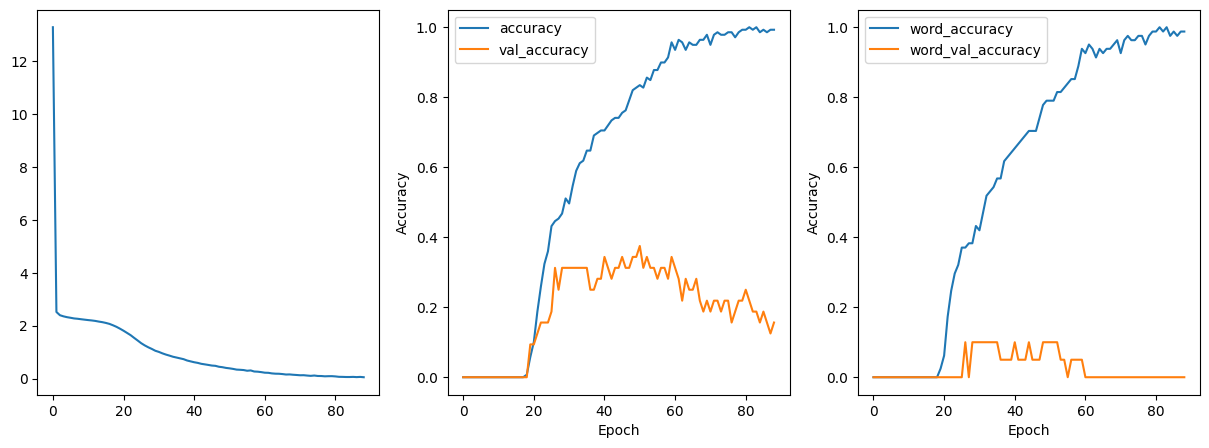

(0.9928057553956835, 0.9876543209876543, 0.15625, 0.0)

In [10]:
result_ith(0, EPOCH, train_batch_size, val_batch_size, device, learning_rate, BLANK)[1:]

 83%|██████████████████████████████████▊       | 83/100 [00:22<00:04,  3.75it/s]


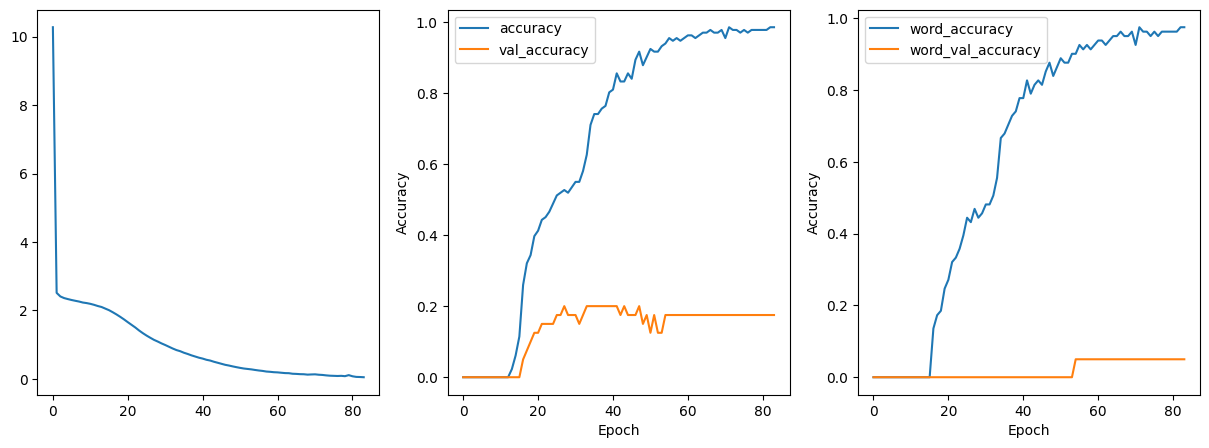

(0.9847328244274809, 0.9753086419753086, 0.175, 0.05)

In [11]:
result_ith(1, EPOCH, train_batch_size, val_batch_size, device, learning_rate, BLANK)[1:]

In [ ]:
result_ith(2, EPOCH, train_batch_size, val_batch_size, device, learning_rate, BLANK)[1:]

In [ ]:
result_ith(3, EPOCH, train_batch_size, val_batch_size, device, learning_rate, BLANK)[1:]

In [ ]:
result_ith(4, EPOCH, train_batch_size, val_batch_size, device, learning_rate, BLANK)[1:]